In [1]:
import numpy as np
from scipy.stats import distributions
import matplotlib.pyplot as plt
from classes.dpm import BaseMeasure, DPM, NormalBaseMeasure
from classes.likelihood import NormalLikelihood
from classes.variables import Normal, InvGamma
plt.style.use("bmh")

In [2]:
mu1 = -2
mu2 = 2
w1 = .7
xmin = -3
xmax = 3

y = np.concatenate([distributions.norm.rvs(loc=mu1, scale=1, size=int(w1*20)), distributions.norm.rvs(loc=mu2, scale=1, size=int((1-w1)*20))])
y = np.array([-1.00665889, 0.06582354, -0.42930577, -1.79629266, -2.36489645, -0.95595253, -2.9021129, -3.91924953, -1.97221089, -3.35683184, 2.71581309, 1.47543713, 2.96155554, 2.42930198, 2.14831234, 2.29008695, 3.17209821, 2.03396742, 2.26676773, 2.66977811,])
s = [0, 1, 2, 3] * 5
xmin = np.min(y) - 1
xmax = np.max(y) + 1
xrange = np.arange(xmin,xmax,0.01)

w1 = int(w1*20) / 20
mu1_actual = np.mean(y[:13])
mu2_actual = np.mean(y[13:])
std1_actual = np.std(y[:13])
std2_actual = np.std(y[13:])

def f(X, w1=w1) -> np.ndarray:
    return w1*distributions.norm.pdf(X, loc=mu1, scale=1) + (1-w1)*distributions.norm.pdf(X, loc=mu2, scale=1)

def f_data(X, w1=w1) -> np.ndarray:
    return w1*distributions.norm.pdf(X, loc=mu1_actual, scale=std1_actual) + (1-w1)*distributions.norm.pdf(X, loc=mu2_actual, scale=std2_actual)

def f2(X, y=y) -> np.ndarray:
    return distributions.norm.pdf(X, loc=np.mean(y), scale=np.std(y))


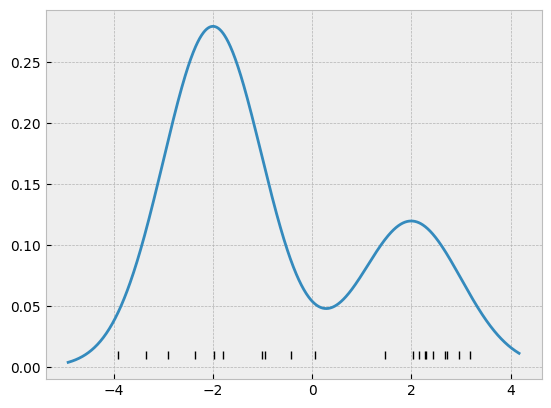

In [3]:
plt.plot(y, [0.01]*len(y), '|', color="k")
plt.plot(xrange, f(xrange))

In [4]:
measures = [
    [-5, 1],
    [-2, 1],
    [2, 1],
    [5, 1]]

base_measure = NormalBaseMeasure([Normal(mu=0,sigma=3), InvGamma()])
dpm = DPM(base_measure, M=0.5)

dpm.set_dataset(y, s)

dpm.set_measures(measures)
dpm.set_weights()

dpm.sample(200)


step:   40/ 200 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
step:   80/ 200 : [1, 2, 1, 1, 3, 1, 1, 1, 1, 3, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0]
step:  120/ 200 : [1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
step:  160/ 200 : [1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0]


In [5]:
def plot_posterior_density(x, results:dict, xmin=xmin, xmax=xmax):
    w = results["w"][:]
    t = results["theta"][:]

    big_X = np.arange(np.min(x)-2, np.max(x)+2, 0.01)

    fig, ax = plt.subplots(1,2, figsize=(12, 6))

    a, b = np.unique(results["n_clusters"], return_counts=True)
    ax[0].bar(x=a, height=b)

    all_y = []
    for i in range(len(w)):
        len_w = len(w[i])

        y = []
        mu = np.array(t[i])[:,0]
        sigma = np.array(t[i])[:,1]

        for j in range(len_w):
            y.append(w[i][j] * distributions.norm.pdf(big_X, loc=mu[j], scale=sigma[j]))

            
        y = np.sum(y, axis=0)
        all_y.append(y)

        # ax[1].plot(big_X, y, color="k", alpha=0.05)
    all_y = np.array(all_y)
    s = np.std(all_y, axis=0)
    m = np.mean(all_y, axis=0)
    ax[1].plot(big_X, m, linestyle="dashed")
    ax[1].fill_between(big_X, m + 1.96*s, np.clip(m - 1.96*s, 0, None), alpha=0.2, color="tab:blue")

    ax[1].plot(x, [0.01]*len(x), '|', color="k")
    # ax[1].plot(np.arange(xmin, xmax, 0.01), f_data(np.arange(xmin, xmax, 0.01)), color="tab:blue")
    ax[1].plot(np.arange(xmin, xmax, 0.01), f(np.arange(xmin, xmax, 0.01)), color="tab:blue")
    # ax[1].plot(np.arange(xmin, xmax, 0.01), f2(np.arange(xmin, xmax, 0.01)), color="red", linestyle="dashed")


In [6]:
chain = dpm._dpm_chain
results = {"w": chain.w, "theta": chain.phi, "n_clusters": chain.n}

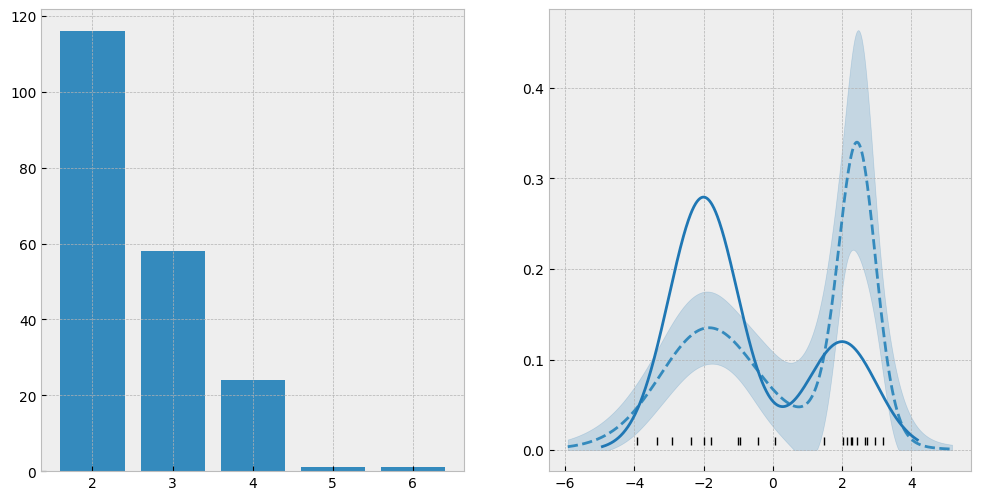

In [7]:
plot_posterior_density(y, results)